# Generative Jazz Licks: Generate Weights

## Summary of this Notebook
* This is the first Notebook for training a generative Model for Jazz Licks
* This Notebook will format the training data in a adequate format for the network which will be further used to generate the weights.
* **Data Preprocessing** 
    * Process Midifiles in a format which is receivable for the Network - This goal is achieved through various functions
    * read_midi_data : Reads midi files from data folder
    * extract_notes_durations : Extracts notes and durations from the midi files
    * build_note_dict : Maps a note to an integer value
    * generate_sequence : Builds a receivable Input Matrix for the network based on the previously extracted Notes and Durations
* **Network** 
    * The Jazz Licks will be Generated with a RNN (LSTM)
    * The Network is based on experimenting + a lot of sources from simelar projects
    * Furthermore an attention mechanism is implemented
* **Training**
    * Various callbacks are used to prevent overfitting 
    * The best amount of training epochs and early stopping was found through experimenting with the parameters
    * Minibatch Gradient is used, because of its performance and robust benefits
    * The weights will be stored in an externel folder, the weights are used in the second Notebook to generate licks based on the folder
    * 3 Networks are created and trained to ensure optimal results based on the licks. This is important because the network could generate strange licks when mixing up diatonic with alterated licks.

# Data Preprocessing

In [10]:
from utils.midi_tools import (extract_notes_and_duration, 
                              generate_sequence, 
                              build_note_dict)

## Set parameters

In [9]:
scale = 'diatonic'
both = True
length = 17

## Calculate Output

### Both

In [11]:
# Extract Notes + Durs from midi files in 'data' Folder
notes, durs = extract_notes_and_duration(scale=scale, show=False, both=both, length=length)
# Represent each Notes + Durations as Numbers
note_int, dur_int = build_note_dict(notes, durs)
# Generate One-Hot-Coded output + valid input data for duration and notes
inputs, outputs = generate_sequence(notes, durs, note_int, dur_int, scale='both', length=length)

# Save amount of unique notes + durs for building the network
n_notes = len(set(notes))
n_durs = len(set(durs))

### Diatonic

In [12]:
notes_dia, durs_dia = extract_notes_and_duration(scale='diatonic', show=False, both=False, length=length)
note_int_dia, dur_int_dia = build_note_dict(notes_dia, durs_dia)
inputs_dia, outputs_dia = generate_sequence(notes_dia, durs_dia, note_int_dia, dur_int_dia, 'diatonic', length=length)

n_notes_dia = len(set(notes_dia))
n_durs_dia = len(set(durs_dia))

### Alterated

In [13]:
notes_alt, durs_alt = extract_notes_and_duration(scale='alterated', show=False, both=False, length=length)
note_int_alt, dur_int_alt = build_note_dict(notes_alt, durs_alt)
inputs_alt, outputs_alt = generate_sequence(notes_alt, durs_alt, note_int_alt, dur_int_alt, 'alterated', length=length)

n_notes_alt = len(set(notes_alt))
n_durs_alt = len(set(durs_alt))

## Compare Different Scales

In [14]:
# Shape m will always be the same
print(f'Inputs Shape: Both {inputs[0].shape}, Diatonic {inputs_dia[0].shape}, Alterated {inputs_alt[0].shape}\n')
# Asserting : Unique Notes = Note Output
print(f'Outputs Shape Notes: Both {outputs[0].shape[1]}, Diatonic {outputs_dia[0].shape[1]}, Alterated {outputs_alt[0].shape[1]}\n')
# Asserting : One Hot Coded Outputs = Unique Durs
print(f'Outputs Shape Durations: Both {outputs[1].shape[1]}, Diatonic {outputs_dia[1].shape[1]}, Alterated {outputs_alt[1].shape[1]}\n')

Inputs Shape: Both (4404, 17), Diatonic (2483, 17), Alterated (1904, 17)

Outputs Shape Notes: Both 35, Diatonic 33, Alterated 33

Outputs Shape Durations: Both 10, Diatonic 6, Alterated 9



# The LSTM-Network

## Imports

In [16]:
from utils.jazz_lstm import generate_lstm_model
from keras.utils import plot_model

## Network Building

In [17]:
jazz_model = generate_lstm_model(n_notes, n_durs)
jazz_model_dia = generate_lstm_model(n_notes_dia, n_durs_dia)
jazz_model_alt = generate_lstm_model(n_notes_alt, n_durs_alt)

2022-12-28 14:24:07.987317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-28 14:24:07.988211: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


## Network Architecture

In [18]:
jazz_model.summary()

Model: "Jazz_LSTM_both"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 note_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 dur_input (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 note_embedd (Embedding)        (None, None, 100)    3500        ['note_input[0][0]']             
                                                                                                  
 dur_embed (Embedding)          (None, None, 100)    1000        ['dur_input[0][0]']              
                                                                                     

In [19]:
# Order: Both, Diatonic, Alterated
jazz_model.count_params(), jazz_model_dia.count_params(), jazz_model_alt.count_params()

(1009602, 1007460, 1008531)

## Indepth Architecture

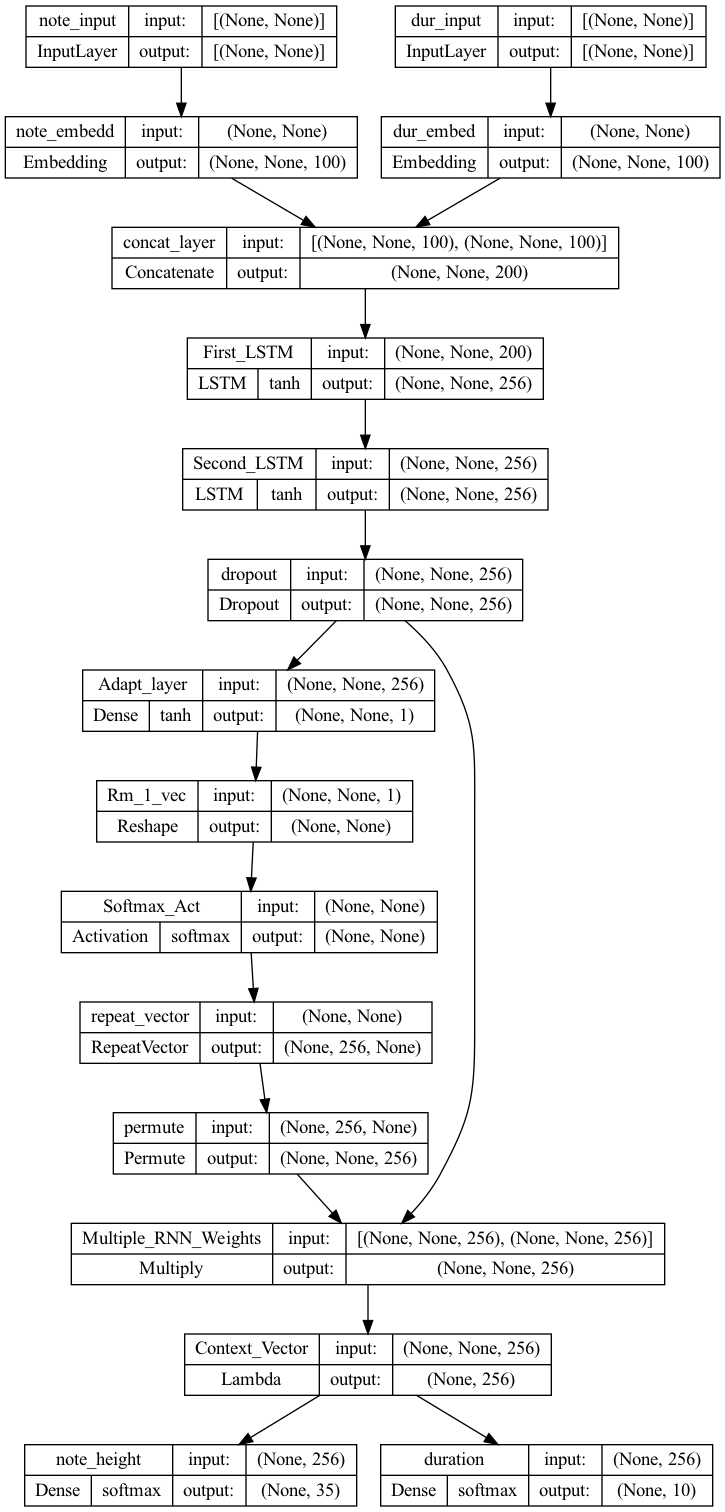

In [20]:
plot_model(jazz_model, to_file='imgs/jazz_model.png', show_shapes=True,
           show_layer_names=True, show_layer_activations=True)

## Training
For getting the optimal results the model will be trained 3 times to cover all possible scales:

* Diatonic 
* Alterated
* Both

When the sequences are generated all results will be observed to determine if the filtering of the scale-type makes a difference or not.
Since the alterated scale material contains a much higher variance of notes, a better performance on diatonic licks is estimated.

In [22]:
from utils.jazz_lstm import train

### Both

In [23]:
train(inputs, outputs, jazz_model, scale, both=both, verbose=1, 
      ep=10, checkpoints=False, bs=16, patience=20)

Epoch 1/10


2022-12-28 14:24:43.348201: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-28 14:24:44.197943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:24:44.395129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:24:44.493663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:24:44.716494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:24:44.836528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


193/193 [==============================] - ETA: 0s - loss: 2.1576 - note_height_loss: 1.7567 - duration_loss: 0.4009

2022-12-28 14:24:51.730713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:24:51.804610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:24:51.850108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: loss improved from inf to 2.15757, saving model to weights/both/weights.h5
193/193 [==============================] - 10s 44ms/step - loss: 2.1576 - note_height_loss: 1.7567 - duration_loss: 0.4009 - val_loss: 1.7813 - val_note_height_loss: 1.5997 - val_duration_loss: 0.1817
Epoch 2/10
193/193 [==============================] - ETA: 0s - loss: 1.7583 - note_height_loss: 1.5611 - duration_loss: 0.1973
Epoch 2: loss improved from 2.15757 to 1.75835, saving model to weights/both/weights.h5
193/193 [==============================] - 8s 39ms/step - loss: 1.7583 - note_height_loss: 1.5611 - duration_loss: 0.1973 - val_loss: 1.7503 - val_note_height_loss: 1.5762 - val_duration_loss: 0.1741
Epoch 3/10
193/193 [==============================] - ETA: 0s - loss: 1.6507 - note_height_loss: 1.5038 - duration_loss: 0.1469
Epoch 3: loss improved from 1.75835 to 1.65068, saving model to weights/both/weights.h5
193/193 [==============================] - 8s 39ms/step - loss: 1.6507 - note_heig

### Diatonic

In [24]:
train(inputs_dia, outputs_dia, jazz_model_dia, 'diatonic', both=False, verbose=1, 
      ep=10, checkpoints=False, bs=16, patience=20)

Epoch 1/10


2022-12-28 14:26:01.603398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:26:01.779548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:26:01.833360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:26:01.990329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  2/109 [..............................] - ETA: 6s - loss: 5.2443 - note_height_loss: 3.4816 - duration_loss: 1.7627  

2022-12-28 14:26:02.082644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


109/109 [==============================] - ETA: 0s - loss: 2.2851 - note_height_loss: 1.8098 - duration_loss: 0.4753

2022-12-28 14:26:06.287343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:26:06.362055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:26:06.421487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: loss improved from inf to 2.28508, saving model to weights/diatonic/weights.h5
109/109 [==============================] - 7s 49ms/step - loss: 2.2851 - note_height_loss: 1.8098 - duration_loss: 0.4753 - val_loss: 1.9384 - val_note_height_loss: 1.6691 - val_duration_loss: 0.2693
Epoch 2/10
109/109 [==============================] - ETA: 0s - loss: 1.7740 - note_height_loss: 1.5261 - duration_loss: 0.2479
Epoch 2: loss improved from 2.28508 to 1.77399, saving model to weights/diatonic/weights.h5
109/109 [==============================] - 4s 41ms/step - loss: 1.7740 - note_height_loss: 1.5261 - duration_loss: 0.2479 - val_loss: 1.9071 - val_note_height_loss: 1.6704 - val_duration_loss: 0.2368
Epoch 3/10
109/109 [==============================] - ETA: 0s - loss: 1.7142 - note_height_loss: 1.5062 - duration_loss: 0.2080
Epoch 3: loss improved from 1.77399 to 1.71418, saving model to weights/diatonic/weights.h5
109/109 [==============================] - 4s 40ms/step - loss: 1.7142 

### Alterated

In [25]:
train(inputs_alt, outputs_alt, jazz_model_alt, 'alterated', both=False, 
      verbose=1, ep=10, checkpoints=False, bs=16, patience=20)

Epoch 1/10


2022-12-28 14:26:48.134498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:26:48.316649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:26:48.385827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:26:48.572348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/84 [..............................] - ETA: 2:00 - loss: 5.6956 - note_height_loss: 3.4938 - duration_loss: 2.2017

2022-12-28 14:26:48.677145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - ETA: 0s - loss: 2.5080 - note_height_loss: 1.9735 - duration_loss: 0.5345

2022-12-28 14:26:52.452806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:26:52.529571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 14:26:52.586838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: loss improved from inf to 2.50802, saving model to weights/alterated/weights.h5
84/84 [==============================] - 6s 57ms/step - loss: 2.5080 - note_height_loss: 1.9735 - duration_loss: 0.5345 - val_loss: 1.9408 - val_note_height_loss: 1.6627 - val_duration_loss: 0.2781
Epoch 2/10
84/84 [==============================] - ETA: 0s - loss: 1.8183 - note_height_loss: 1.6036 - duration_loss: 0.2148
Epoch 2: loss improved from 2.50802 to 1.81833, saving model to weights/alterated/weights.h5
84/84 [==============================] - 4s 43ms/step - loss: 1.8183 - note_height_loss: 1.6036 - duration_loss: 0.2148 - val_loss: 1.9118 - val_note_height_loss: 1.6345 - val_duration_loss: 0.2773
Epoch 3/10
83/84 [============================>.] - ETA: 0s - loss: 1.7377 - note_height_loss: 1.5555 - duration_loss: 0.1822
Epoch 3: loss improved from 1.81833 to 1.73611, saving model to weights/alterated/weights.h5
84/84 [==============================] - 4s 44ms/step - loss: 1.7361 - note_